In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import sparse
from scipy.linalg import sqrtm
from sklearn import preprocessing
from pandas.api.types import CategoricalDtype
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE

## DATA

In [2]:
data = pd.read_csv('data/pic50_chembl_targets.csv')
data

,type,value,chembl,target
0,IC50,5.000,CHEMBL1086997,1
1,IC50,5.365,CHEMBL1029,1
2,IC50,8.310,CHEMBL2051983,1
3,IC50,4.770,CHEMBL422734,1
4,IC50,4.440,CHEMBL240080,1
...,...,...,...,...
35480,IC50,5.580,CHEMBL1650803,80
35481,IC50,6.700,CHEMBL109278,80
35482,IC50,8.260,CHEMBL320478,80
35483,IC50,7.300,CHEMBL266263,80


In [3]:
le = preprocessing.LabelEncoder()
le.fit(data.chembl)

data['molId'] = le.transform(data.chembl).astype('str')
data['targetId'] = data.target.astype('str')
data = data[['molId', 'targetId', 'value']]

## Train test split

In [4]:
train, test, _, _ = train_test_split(data, data.value, test_size=0.33, random_state=0, stratify=data.targetId)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

## SVD and predict

In [7]:
features = [4, 8, 16, 32, 124]
spMat, targets_index, mols_index = create_sp_matrix(train)


for k, f in enumerate(features):
    idx = []
    i = 0
    ole = []
    preds = [] 
    filledMat = svd(spMat, k=f)

    for _, row in test.iterrows():
        i += 1
        mol = row['molId']
        target = row['targetId']
        t_index = targets_index[target]
        if mol in mols_index:
            m_index = mols_index[mol]
            pred_value = filledMat[t_index, m_index]
        else:
            pred_value = np.mean(filledMat[t_index, :])
        preds.append(pred_value)
        
    print('MSE for {} features : {:.4f}'.format(str(features[k]), MSE(test['value'], preds)))

MSE for 4 features : 1.6603
MSE for 8 features : 1.6595
MSE for 16 features : 1.6594
MSE for 32 features : 1.6590
MSE for 124 features : 1.6590


## Exploration

In [8]:
spMat.head()

,23046,23853,5360,13386,1300,15361,14290,22554,15548,4183,...,24786,22149,11086,19868,9915,8684,1520,10371,19568,22065
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.38
48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65,NaN,NaN,NaN,5.96,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.04,NaN,NaN,NaN,NaN,NaN,NaN


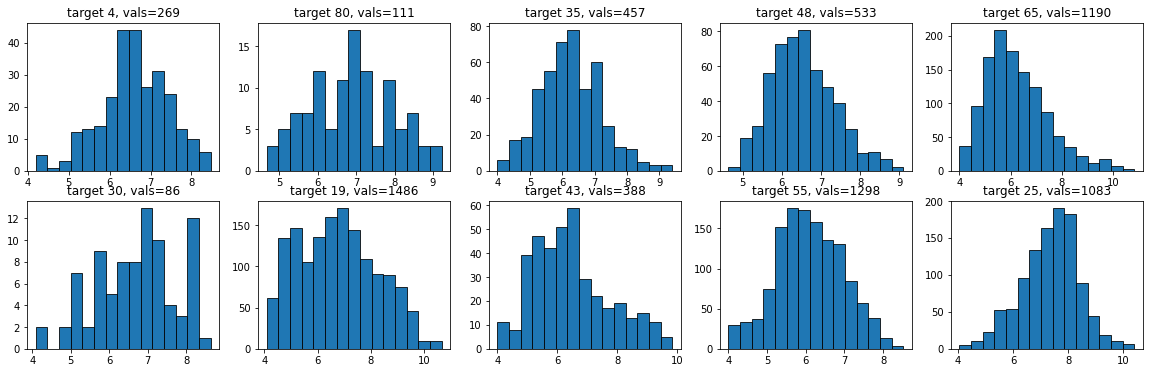

In [9]:
plt.figure(figsize=(20,6))
kwargs = {'edgecolor':'black', 'linewidth':0.8}

for i in range(10):
    plt.subplot(2, 5, i+1)
    vals = spMat.iloc[i,:].count()
    name = 'target ' + str(spMat.index[i]) + ', vals=' + str(vals)   
    
    spMat.iloc[i,:].hist(bins=15, grid=False, **kwargs)
    plt.title(name)
    

## Sparse mats with scipy

In [10]:
molecules = data['molId'].unique()
targets = data['targetId'].unique()
shape = (len(molecules), len(targets))

mols_cat = CategoricalDtype(categories=sorted(molecules), ordered=True)
targets_cat = CategoricalDtype(categories=sorted(targets), ordered=True)
mol_index = data["molId"].astype(mols_cat).cat.codes
target_index = data["targetId"].astype(targets_cat).cat.codes

# I would recommend using COO matrices for bigger datasets
coo = sparse.coo_matrix((data["value"], (mol_index, target_index)), shape=shape)
csr = coo.tocsr()

In [5]:
def svd(spMat, k):
    mask = np.isnan(spMat)
    masked_arr = np.ma.masked_array(spMat, mask)
    item_means = np.mean(masked_arr, axis=0)
    spMat = masked_arr.filled(item_means)
    x = np.tile(item_means, (spMat.shape[0],1))
    spMat = spMat - x
    U, s, V=np.linalg.svd(spMat, full_matrices=False)
    s=np.diag(s)
    
    # let's take just the most significant features
    s=s[0:k,0:k]
    U=U[:,0:k]
    V=V[0:k,:]
    
    s_root=sqrtm(s)
    Usk=np.dot(U,s_root)
    skV=np.dot(s_root,V)
    UsV = np.dot(Usk, skV)
    UsV = UsV + x

    return UsV

In [6]:
def create_sp_matrix(data):        

    moleculesList = data.iloc[:,0].values
    targetsList = data.iloc[:,1].values
    valuesList = data.iloc[:,2].values
    
    molecules = list(set(data.iloc[:,0]))
    targets = list(set(data.iloc[:,1]))
    
    mol_index = {molecules[i]: i for i in range(len(molecules))}
    d = {target: [np.nan for i in range(len(molecules))] for target in targets}
    
    for i in range(0,len(data)):
        target = targetsList[i]
        molecule = moleculesList[i]
        value = valuesList[i]
        
        d[target][mol_index[molecule]] = value
    
    X = pd.DataFrame(d)
    X.index = molecules
        
    targetcols = list(X.columns)
    targets_index = {targetcols[i]: i for i in range(len(targetcols))}

    return X.T, targets_index, mol_index